In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import ruptures as rpt
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.metrics import auc

# Dane

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/vlosing/driftDatasets/master/artificial/hyperplane/rotatingHyperplane.data', sep = '\s+', header = None)
labels = pd.read_csv('https://raw.githubusercontent.com/vlosing/driftDatasets/master/artificial/hyperplane/rotatingHyperplane.labels', sep = '\s+', header = None)

In [3]:
data.head()

,0,1,2,3,4,5,6,7,8,9
0,0.397174,0.347518,0.294057,0.506484,0.115967,0.770536,0.659893,0.156747,0.378202,0.139763
1,0.275030,0.075388,0.610592,0.954931,0.274069,0.190202,0.001299,0.683527,0.486260,0.487515
2,0.233156,0.889909,0.038327,0.592379,0.655174,0.119839,0.652477,0.984323,0.206738,0.374650
3,0.277937,0.340915,0.265790,0.116670,0.136830,0.546089,0.494619,0.015384,0.358995,0.242478
4,0.254909,0.777916,0.225022,0.983103,0.803619,0.836315,0.163104,0.637497,0.008760,0.631190


In [4]:
labels.head()

,0
0,0
1,0
2,1
3,0
4,0


In [5]:
int(0.1*len(labels))

20000

In [74]:
first_subset_data = data.head(int(0.1*len(data)))
first_subset_labels = labels.head(int(0.1*len(labels))).values.reshape(-1)
second_subset_data = data.tail(int(0.1*len(data)))
second_subset_labels = labels.tail(int(0.1*len(labels))).values.reshape(-1)

In [75]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(first_subset_data, first_subset_labels , test_size = 0.2, random_state=0)

In [76]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(second_subset_data, second_subset_labels , test_size = 0.2, random_state=0)

# Modele

In [77]:
model_1 = LogisticRegression()
model_1.fit(X_train_1, y_train_1)
model_2 = LogisticRegression()
model_2.fit(X_train_2, y_train_2)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

# Variable drift

In [78]:
def variable_drift(x, y, subplot):
    concat = pd.concat([x, y])
    bins = concat.quantile(np.linspace(0, 1, 51))
    plt.subplot(*subplot)
    hist_x = plt.hist(x, bins=bins, alpha=0.5, label="Old", normed = True)
    hist_y = plt.hist(y, bins=bins, alpha=0.5, label="New", normed = True)
    
    plt.legend()
    intersect = np.minimum(hist_x[0], hist_y[0]) @ np.diff(bins)
    plt.text(x=0, y=0.25, s='The intersection is {:.4f}'.format(intersect))

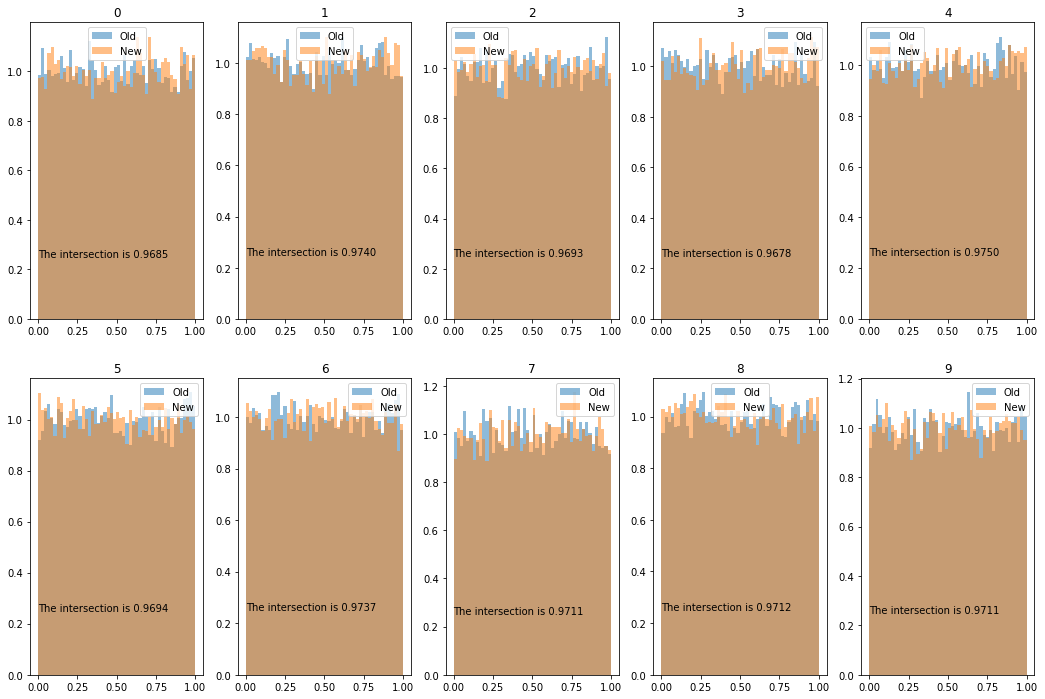

In [79]:
plt.figure(figsize=(18,12))
for i in range(10):
    variable_drift(first_subset_data.loc[:,i], second_subset_data.loc[:,i], subplot=(2, 5, i+1))
    plt.title(str(i))
plt.show(block=True)

Nie ma dużych zmian w rozkładzie zmiennych dla pierwszych 10% zbioru i ostatnich 10% zbioru. Zmiana jest < 0.05.

# Residuals drift

In [80]:
def residuals_drift(x, y):
    concat = pd.concat([x, y])
    bins = concat.quantile(np.linspace(0, 1, 51))
    hist_x = plt.hist(x, bins=bins, alpha=0.5, label="Old", normed = True)
    hist_y = plt.hist(y, bins=bins, alpha=0.5, label="New", normed = True)
    
    plt.legend()
    intersect = np.minimum(hist_x[0], hist_y[0]) @ np.diff(bins)
    plt.text(x=0, y=0.25, s='The intersection is {:.4f}'.format(intersect))
    plt.show()

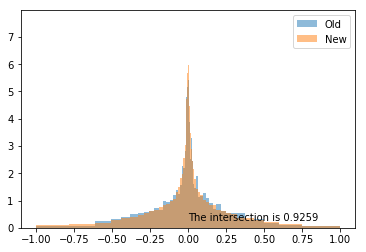

In [84]:
residuals_drift(pd.Series(y_test_1 - model_1.predict_proba(X_test_1)[:, 1]), 
               pd.Series(second_subset_labels - model_2.predict_proba(second_subset_data)[:, 1]))

Nie ma zmian dla reszt obu modeli

# PD plot difference

In [115]:
def pd_plot_diff(model1, model2, X1, X2, no_points = 100):
    fig, ax_tuple = plt.subplots(2, 5, sharey=True, figsize=(18,12))
    for feature_index, var in enumerate(X1.columns):
        x_1 = pd.concat([X1] * no_points)
        x_2 = pd.concat([X2] * no_points)
        x_1[var] = np.repeat(np.linspace(X1[var].min(), X1[var].max(), no_points), X1.shape[0])
        x_2[var] = np.repeat(np.linspace(X2[var].min(), X2[var].max(), no_points), X2.shape[0])
        x_1['preds'] = model1.predict_proba(x_1)[:,1]
        x_2['preds'] = model2.predict_proba(x_2)[:,1]
        x_1 = x_1.groupby(var).agg({'preds':'mean'}).reset_index()
        x_2 = x_2.groupby(var).agg({'preds':'mean'}).reset_index()
        curr_ax = ax_tuple[feature_index // 5, feature_index % 5]
        curr_ax.plot(x_1[var], x_1['preds'], label='old', color = 'red')
        curr_ax.plot(x_2[var], x_2['preds'], color='black', label='new')
        curr_ax.fill_between(x_1[var], x_1['preds'], x_2['preds'], 
                             where=x_2['preds'] >= x_1['preds'], facecolor='green', 
                             alpha=0.3, interpolate=True)
        curr_ax.fill_between(x_1[var], x_1['preds'], x_2['preds'], 
                             where=x_2['preds'] < x_1['preds'], facecolor='red', 
                             alpha=0.3, interpolate=True)
        area = (x_1['preds'] - x_2['preds']).abs().iloc[1:] @ np.diff(x_1[var])
        curr_ax.text(x=0, y=0.1, s='Area between curves: {:.4f}'.format(area))
        curr_ax.set_title('Variable {}'.format(str(feature_index)))
        curr_ax.legend()

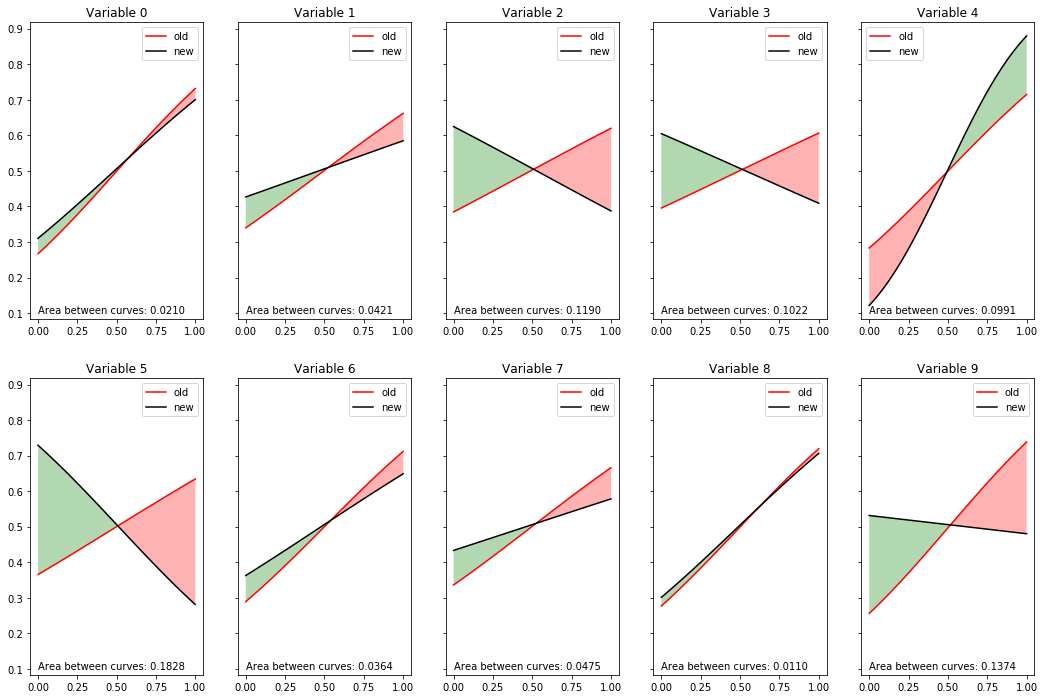

In [116]:
pd_plot_diff(model_1, model_2, X_test_1, X_test_2)

Widać zmianę w profilach PDP dla modeli. Największa dla zmiennych 2, 3, 5 i 9.
Concept drift dla tych danych i modeli następuje w profilach PDP.